In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import nd2
import numpy as np
import os
import pandas as pd
import imagej
import scyjava as sj

In [2]:
num='02'
path = f'..\data\iScat\Data\\2024_11_11\\Metasurface\\Chip_02\\Metasurface {num}\\Brightfield'
z_stack_path = path+f'\\02_{num}_BF.nd2'
f1_path = path+'\\Captured Cy5.tif'
f2_path = path+'\\Captured FITC.tif'
f3_path = path+'\\Captured TRITC.tif'
f1_results = path+"\\Cy5.csv"
f2_results = path+"\\FITC.csv"
f3_results = path+"\\TRITC.csv"
z_stack_image = nd2.imread(z_stack_path)
f1_img =  Image.open(f1_path)
f2_img =  Image.open(f2_path)
f3_img =  Image.open(f3_path)

In [3]:
class Labeler:

    def __init__(self,):
        self.ij = imagej.init(ij_dir_or_version_or_endpoint='D:\Fiji.app',mode=imagej.Mode.HEADLESS)
        print(f"ImageJ2 version: {self.ij.getVersion()}")
        pass

    def create_labels_mask(self, canvas_shape, particles_positions):
        """
            canvas_shape: tuple of image shape (height, width)
            particles_positions: list of pandas dataframe of bounding box of particles in each image
            return: numpy array of labels (mask)
        """
        # Preallocate canvas
        label_canvas = np.zeros(canvas_shape, dtype=np.uint8)

        # Precompute y, x coordinates
        y, x = np.ogrid[:canvas_shape[0], :canvas_shape[1]]

        for particle_data in particles_positions:
            for _, row in particle_data.iterrows():
                # Compute ellipse parameters
                center_x = int((row['xMin'] + row['xMax']) / 2)
                center_y = int((row['yMin'] + row['yMax']) / 2)
                axes_x = int((row['xMax'] - row['xMin']) / 2)
                axes_y = int((row['yMax'] - row['yMin']) / 2)

                # Vectorized ellipse mask creation
                mask = ((x - center_x) / axes_x)**2 + ((y - center_y) / axes_y)**2 <= 1

                # Efficient overlap and labeling
                label_canvas[mask & (label_canvas == 1)] = 2
                label_canvas[mask & (label_canvas == 0)] = 1

        return label_canvas 

    def label(self,fluo_images_paths,seg_args,segmentation_method="comdet"):
        """
        fluo_images_paths: list of fluorecense images paths
        seg_args: list of segmentation arguments
        segmentation_method: method to segment the particles
        return: numpy array of labels (mask)
        """
        if segmentation_method == "comdet":
            particles_positions = []
            for image_path,args in zip(fluo_images_paths,seg_args):
                particles_position_path = image_path.replace(".tif",".csv")
                if not os.path.exists(particles_position_path):  
                    image = self.ij.IJ.openImage(image_path)            
                    self.ij.py.run_plugin(plugin="Detect Particles",args=args,imp=image)
                    table = self.ij.ResultsTable.getResultsTable()
                    Table = sj.jimport('org.scijava.table.Table')
                    results = self.ij.convert().convert(table, Table)
                    results = self.ij.py.from_java(results)        
                    results.to_csv(particles_position_path)
                    particles_positions.append(results)
                else:
                    particles_positions.append(pd.read_csv(particles_position_path))
            canvas_shape = np.array(Image.open(fluo_images_paths[0])).shape
            mask = self.create_labels_mask(canvas_shape, particles_positions)
        else:
            raise ValueError("Invalid segmentation method")
        return mask


In [4]:
labeler= Labeler()

ImageJ2 version: 2.14.0/1.54f


In [5]:
fluorescence_images_paths = [f1_path,f2_path,f3_path]
args={
    "ch1i":True,
    "ch1a":4,
    "ch1s":10
}
seg_args = [args,args,args]
mask = labeler.label(fluorescence_images_paths,seg_args,segmentation_method="comdet")

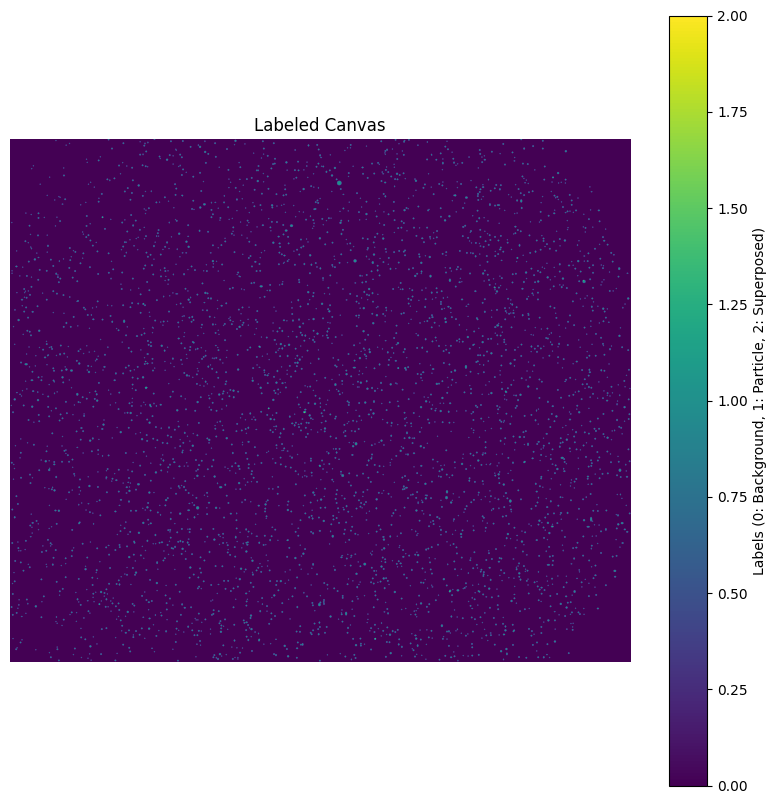

In [6]:
def visualize_labeled_canvas(mask): 
    # Plot the labeled canvas
    plt.figure(figsize=(10, 10))
    plt.title("Labeled Canvas")
    plt.imshow(mask, cmap='viridis')
    plt.colorbar(label="Labels (0: Background, 1: Particle, 2: Superposed)")
    plt.axis('off')
    plt.show()
visualize_labeled_canvas(mask)

In [7]:
u,c=np.unique(mask, return_counts=True)
print(c)

[5426673  102633     294]


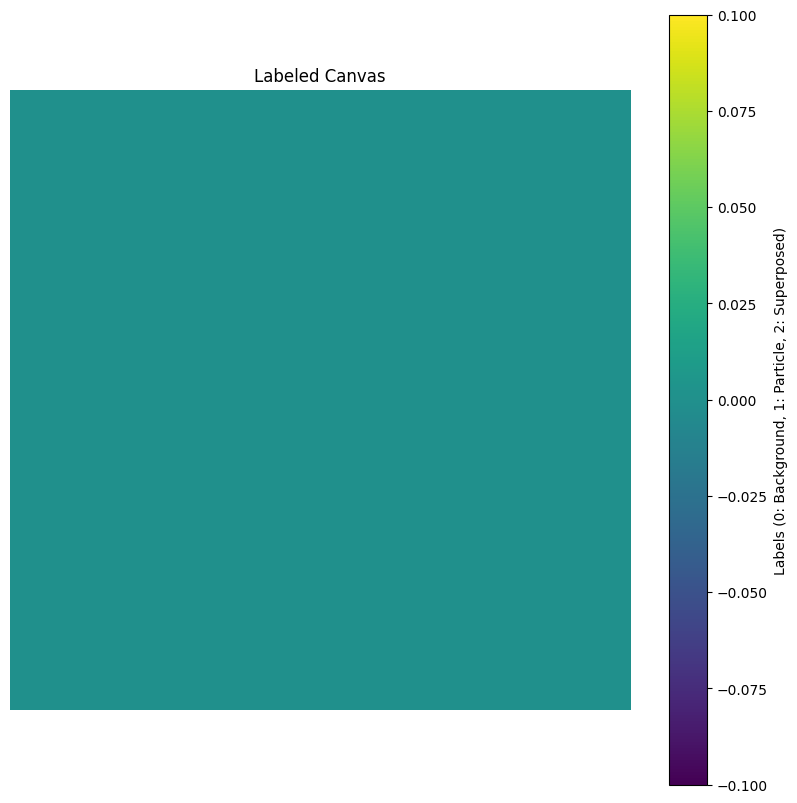

In [8]:
plt.figure(figsize=(10, 10))
plt.title("Labeled Canvas")
plt.imshow(mask[580:590,510:520] , cmap='viridis')
plt.colorbar(label="Labels (0: Background, 1: Particle, 2: Superposed)")
plt.axis('off')
plt.show()